<a href="https://colab.research.google.com/github/ArnavJalan-30/digital_image_processing/blob/main/Anisotropic_Diffusion_2210110192.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Prerequisite [10 Marks]
* Load required packages and load images (already uploaded on Blackboard) in Colab
* Create your own copy of notebook and add required code snippets in between the questions subsections. Also display the figures at each stage.
*Submit the lab on Blackboard by Feb 19, 2024 in **.ipynb** format.
*Colab can be exported as a notebook file or Python file by **File > Download .ipynb** or **File > Download .py**. Exported notebook files can be reloaded into Google Colab or used in Jupyter Notebook.
* Please go through [Colab document](https://colab.research.google.com/drive/1YKHHLSlG-B9Ez2-zf-YFxXTVgfC_Aqtt) for further information.

* **Use ONLY following basic tensorflow and numpy functions for any type of  operations**



In [54]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt


#A) Load Image 'xray_circuit.jpg'



Original Data_type is uint8
Data_type is uint8
Image Size is (495, 447, 1)
Image min and max are (0, 255)


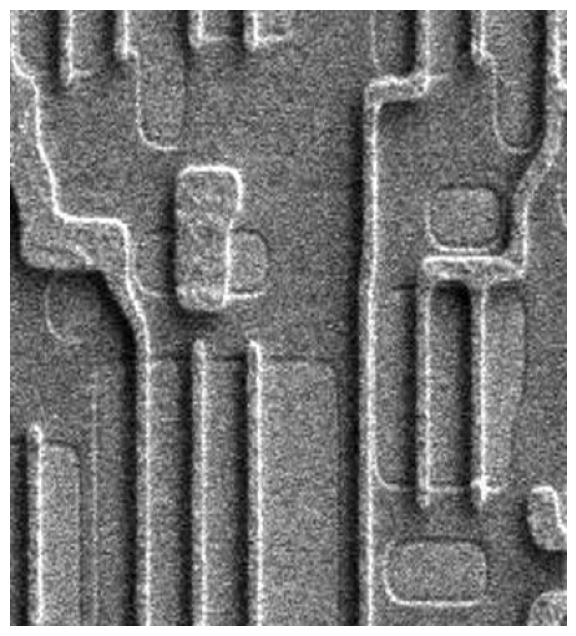

In [55]:
img_path = '/content/xray_circuit.jpg'
img =  tf.io.read_file(img_path)
img_a = tf.io.decode_jpeg(img)
img_a = tf.image.rgb_to_grayscale(img_a).numpy()
print('Original Data_type is {}'.format(img_a.dtype))
print('Data_type is', img_a.dtype)
print('Image Size is {}'.format(img_a.shape))
print('Image min and max are ({}, {})'.format(img_a.min(),img_a.max()))
#################################################
plt.figure(figsize=(8,8))
plt.imshow(img_a, cmap='gray')
plt.axis('off')
plt.show()

#B) Apply Isotropic Diffusion using 5x5 gaussian filter by applying it 10 times

In [56]:
frange = np.arange(-2,3)
[X,Y] = np.meshgrid(frange,frange,indexing='ij')
filter = np.exp(-(X**2+Y**2)/2)
fsum = filter.ravel().sum()
filter /= fsum

In [57]:
filter,filter.ravel().sum()

(array([[0.00296902, 0.01330621, 0.02193823, 0.01330621, 0.00296902],
        [0.01330621, 0.0596343 , 0.09832033, 0.0596343 , 0.01330621],
        [0.02193823, 0.09832033, 0.16210282, 0.09832033, 0.02193823],
        [0.01330621, 0.0596343 , 0.09832033, 0.0596343 , 0.01330621],
        [0.00296902, 0.01330621, 0.02193823, 0.01330621, 0.00296902]]),
 1.0)

In [58]:
img_a.shape

(495, 447, 1)

In [59]:
gauss_filter = tf.constant(filter, shape=(5, 5, 1, 1))
img_a1 = tf.constant(img_a, shape=(1,img_a.shape[0], \
                                   img_a.shape[1], img_a.shape[2]))
img_a1 = tf.cast(img_a1, tf.float64)
img_b = img_a1
for i in range(10):
  img_b = tf.nn.conv2d(img_b, gauss_filter, \
                       strides=[1, 1, 1, 1], padding='SAME')


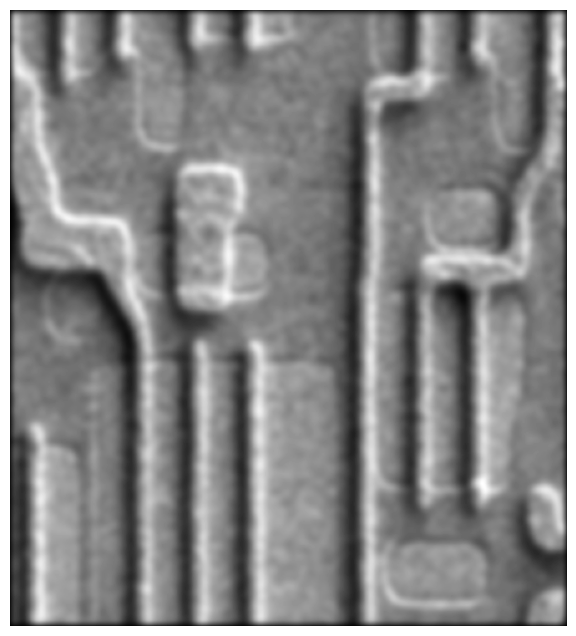

In [60]:
plt.figure(figsize=(8,8))
plt.imshow(img_b.numpy().astype(np.uint8).squeeze(), cmap='gray')
plt.axis('off')
plt.show()

In [61]:
img_b.shape

TensorShape([1, 495, 447, 1])

#C) Apply Non-linear Isotropic Diffusion using 5x5 thresholded gaussian filter [5 Marks]

In [62]:
#
frange = np.arange(-2,3)
[X,Y] = np.meshgrid(frange,frange, indexing='ij')
filter = np.exp(-(X**2 + Y**2)/2)
filter /= filter.ravel().sum()

In [63]:
filter,filter.ravel().sum()

(array([[0.00296902, 0.01330621, 0.02193823, 0.01330621, 0.00296902],
        [0.01330621, 0.0596343 , 0.09832033, 0.0596343 , 0.01330621],
        [0.02193823, 0.09832033, 0.16210282, 0.09832033, 0.02193823],
        [0.01330621, 0.0596343 , 0.09832033, 0.0596343 , 0.01330621],
        [0.00296902, 0.01330621, 0.02193823, 0.01330621, 0.00296902]]),
 1.0)

In [64]:
# Define the Gaussian filter for isotropic diffusion
frange = np.arange(-2, 3)
[X, Y] = np.meshgrid(frange, frange, indexing='ij')
filter = np.exp(-(X**2 + Y**2) / 2)
filter /= filter.ravel().sum()
gauss_filter = tf.constant(filter, shape=(5, 5, 1, 1))

# Filter to measure dI/dx
dx_filter = tf.constant([[-1, 0, 1]], dtype=tf.float64, shape=(1, 3, 1, 1))

# Filter to measure dI/dy
dy_filter = tf.constant([[-1], [0], [1]], dtype=tf.float64, shape=(3, 1, 1, 1))

# Initialize the image tensor
img_b1 = tf.constant(img_a, shape=(1, img_a.shape[0], img_a.shape[1], 1), dtype=tf.float64)

# Looping over iterations
for i in range(10):
    # Compute image gradients
    grad_x = tf.nn.conv2d(img_b1, dx_filter, strides=[1, 1, 1, 1], padding='SAME')
    grad_y = tf.nn.conv2d(img_b1, dy_filter, strides=[1, 1, 1, 1], padding='SAME')

    # Compute gradient magnitude
    gradient = tf.abs(grad_x) + tf.abs(grad_y)

    # Compute diffusion term
    gradient_squared = gradient**2
    k = 34
    diffusion_term = gradient_squared / k**2

    # Compute exponential of the negative diffusion term
    exp_diffusion_term = tf.exp(-diffusion_term)

    # Compute numerator
    numerator = img_b1 * exp_diffusion_term
    numerator = tf.nn.conv2d(numerator, gauss_filter, strides=[1, 1, 1, 1], padding='SAME')

    # Compute denominator
    denominator = tf.nn.conv2d(exp_diffusion_term, gauss_filter, strides=[1, 1, 1, 1], padding='SAME')

    # Update image
    img_b1 = numerator / denominator


Data_type is float64
Image Size is (495, 447)
Image min and max are (8.234702776652995, 252.25423998611802)


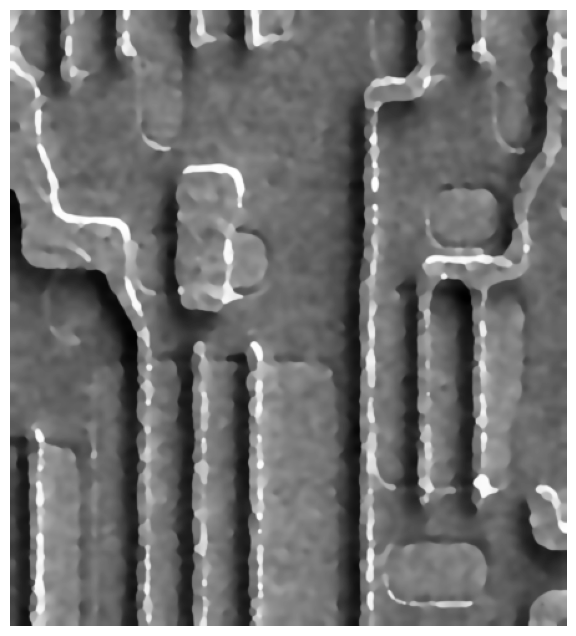

In [65]:
img_b11 = img_b1.numpy().squeeze()
print('Data_type is', img_b11.dtype)
print('Image Size is {}'.format(img_b11.shape))
print('Image min and max are ({}, {})'.format(img_b11.min(),img_b11.max()))

plt.figure(figsize=(8,8))
plt.imshow(img_b11.astype(np.uint8), cmap='gray')
plt.axis('off')
plt.show()

#D) Implement Anisotropic diffusion [5 Marks]

Initialize Variables


In [66]:
a_min=img_a.min()
a_max=img_a.max()

niter = 100 # number of gradient descent iteration.
option = 2 # 1 Perona Malik diffusion equation No 1
           # 2 Perona Malik diffusion equation No 2
kappa = 8  #8 # conductance coeefficient
step = (1,1)
lambDA = 0.15


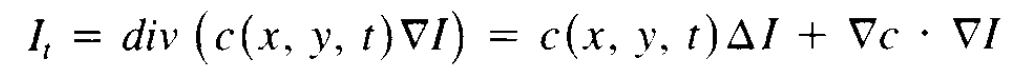
Option-1--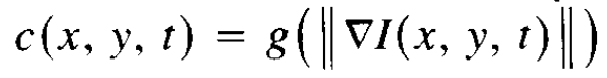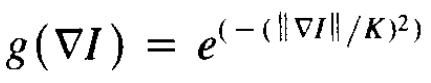

Option-2--
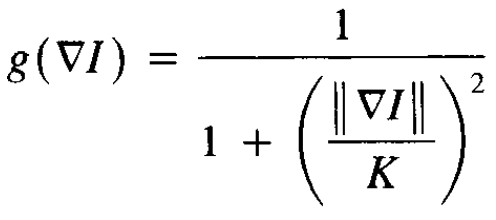

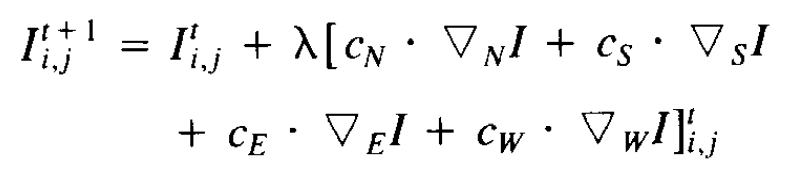

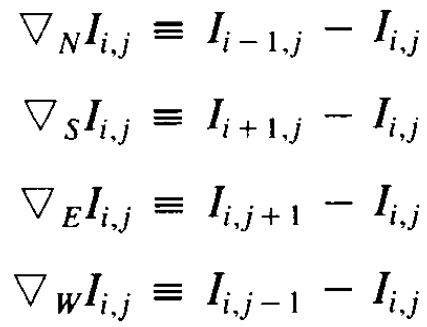
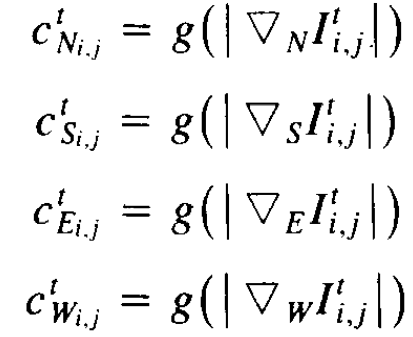

In [70]:
import tensorflow as tf

# Define the anisotropic diffusion function
def anisotropic(image, niter, kappa, option, step, lambdA):
    img = image.numpy().copy().astype('float32')

    for _ in range(niter):
        gradient_x = tf.nn.conv2d(img, dx_filter, strides=[1, 1, 1, 1], padding='SAME')
        gradient_y = tf.nn.conv2d(img, dy_filter, strides=[1, 1, 1, 1], padding='SAME')

        if option == 1:
            c = tf.exp(-(gradient_y / kappa) ** 2)

        elif option == 2:
            c = 1 / (1 + (gradient_y / kappa) ** 2)

        else:
            continue

        img += lambdA * (c * gradient_y + c * gradient_y + c * gradient_x + c * gradient_x)

    return tf.convert_to_tensor(img)

# Assuming img_a1 is defined as you provided in the previous code snippet
img_a1 = tf.expand_dims(img_a, axis=-1)

# Define Sobel filters (assuming they are 3x3 filters)
dx_filter = tf.constant([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=tf.float32)
dy_filter = tf.constant([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=tf.float32)

# Reshape the filters to have the appropriate shape
dx_filter = tf.reshape(dx_filter, [3, 3, 1, 1])
dy_filter = tf.reshape(dy_filter, [3, 3, 1, 1])

# Apply anisotropic diffusion with option 1 and 2
img_d1 = anisotropic(img_a1, niter, kappa, 1, step, lambDA)
img_d2 = anisotropic(img_a1, niter, kappa, 2, step, lambDA)


ImageOut min and max are (-40.0803108215332, 339.7121276855469)
Img_c1 min and max are (0.0, 1.0)
Data_type is uint8
Image Size is (495, 447, 1, 1)
Image min and max are (0, 255)


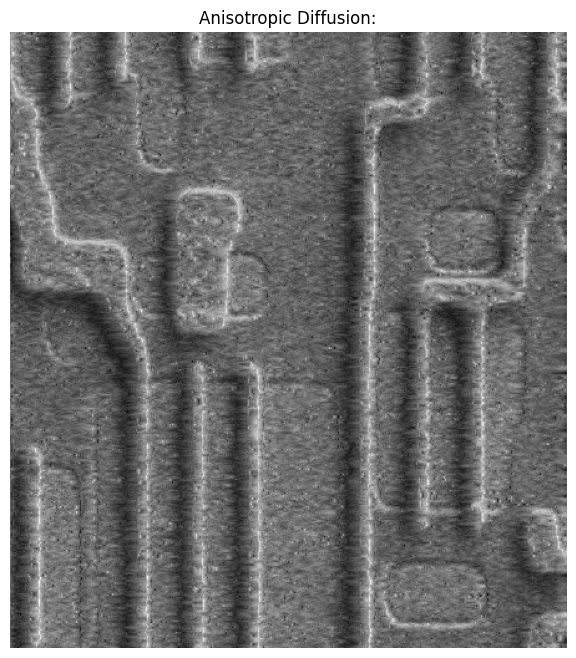

In [69]:
#imageout is output of Anisotropic diffusion process
imgout = img_d2.numpy()
print('ImageOut min and max are ({}, {})'.format(imgout.min(),imgout.max()))
img_c1 = (imgout - imgout.min())/(imgout.max()-imgout.min())
print('Img_c1 min and max are ({}, {})'.format(img_c1.min(),img_c1.max()))
img_c = img_c1*(a_max-a_min) + a_min
img_c = img_c.astype(np.uint8)
print('Data_type is', img_c.dtype)
print('Image Size is {}'.format(img_c.shape))
print('Image min and max are ({}, {})'.format(img_c.min(),img_c.max()))
#################################################
img_c = np.squeeze(img_c)
plt.figure(figsize=(8,8))
plt.imshow(img_c, cmap='gray')
plt.title('Anisotropic Diffusion:')
plt.axis('off')
plt.show()